# Install and import libs

In [1]:
%%capture
!pip install transformers

In [2]:
import torch
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer, get_linear_schedule_with_warmup
from transformers.modeling_outputs import SequenceClassifierOutput

import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from typing import Any, Union, Tuple, List, Dict

# Support funcs

In [3]:
def get_formated_label(label: int, num_labels: int) -> List[int]:
  '''Getting formated label for NN'''
  formated_label = [0]*num_labels
  formated_label[label] = 1
  return formated_label

# Classes

In [4]:
class Dataset(torch.utils.data.Dataset):
  
  def __init__(self, seqs: list, labels: list, tokenizer: object, num_labels: int):
    self.tokenized = [tokenizer(seq, max_length=512, padding='max_length') for seq in seqs] # max_length=512 'cause max_position_embeddings=512 in bert
    self.formated_labels = [get_formated_label(label, num_labels) for label in labels]

  def __getitem__(self, i) -> Tuple[Dict[str, torch.tensor], torch.tensor]:
    tokenized = {k: torch.tensor(v) for k, v in self.tokenized[i].items()}
    formated_label = torch.tensor(self.formated_labels[i]).float()
    return tokenized, formated_label
  
  def __len__(self) -> int:
    return len(self.tokenized)

In [5]:
class IntentClassifier(torch.nn.Module):

  def __init__(self, pretrained_bert_model: str, num_labels: int, load_bert_model_state_dict: bool = True):
    super(IntentClassifier, self).__init__()
    self.pretrained_bert_model = pretrained_bert_model
    self.num_labels = num_labels

    self.tokenizer = BertTokenizer.from_pretrained(self.pretrained_bert_model)

    # layers
    if load_bert_model_state_dict:
      self.bertfsc = BertForSequenceClassification.from_pretrained(self.pretrained_bert_model, num_labels=self.num_labels)
    else:
      self.bertfsc = BertForSequenceClassification(BertConfig.from_pretrained(self.pretrained_bert_model), num_labels=self.num_labels)

    if torch.cuda.is_available():
      self.device = torch.device('cuda:0')
    else:
      self.device = torch.device('cpu')
  
  
  def forward(self, input_ids: torch.tensor, attention_mask: torch.tensor, token_type_ids: torch.tensor, labels: torch.tensor = None) -> SequenceClassifierOutput:
    bertfsc_output = self.bertfsc(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
    return bertfsc_output

  
  def train(self, dataloader: torch.utils.data.DataLoader(Dataset), epochs: int) -> List[float]:
    '''Training layers (without untrained) with dataloader of Dataset
    with optim func **AdamW**'''
    optimizer = torch.optim.AdamW(self.parameters())

    num_training_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    # for statistics
    train_loss, history_train_loss = 0.0, list()
    ebfs = len(train_dataloader) / 10 # ebfc - every batch for statistics

    for epoch in range(epochs):
      for i, batch in enumerate(train_dataloader):
        input_ids = batch[0]['input_ids'].to(self.device)
        attention_mask = batch[0]['attention_mask'].to(self.device)
        token_type_ids = batch[0]['token_type_ids'].to(self.device)
        formated_labels = batch[1].to(self.device)

        self.zero_grad()

        forward_output = self.forward(input_ids, attention_mask, token_type_ids, formated_labels)
        loss = forward_output[0]
        loss.backward()

        # for statistics
        train_loss += loss.item()
        if i % ebfs == ebfs - 1:
            print(f"[Epoch: {epoch + 1}, batch: {i + 1:5d}]. Loss: {train_loss / ebfs:.3f}")
            history_train_loss.append(train_loss / ebfs)
            train_loss = 0.0
        
        torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
    
    print("Training is finish.")
    return history_train_loss
  

  def load(self, fp: str):
    '''Loading state dict (weights and biases) from pytorch checkpoint'''
    self.load_state_dict(torch.load(fp))

  
  def predict(self, text: str) -> Dict[str, Union[int, float]]:
    
    tokenized = self.tokenizer(text, return_tensors='pt').to(self.device)
    forward_output = self.forward(tokenized['input_ids'], tokenized['attention_mask'], tokenized['token_type_ids'])
    logits = forward_output[0]

    max_prob_label, max_prob = -1, -1
    for label, prob in enumerate(logits[0], 0):
      prob = prob.item()
      if prob > max_prob:
        max_prob_label, max_prob = label, prob
    
    if max_prob < 0.51:
      max_prob_label, max_prob = 6, 1.0 - torch.mean(logits[0]).item()

    print(logits) # for debug
    return {'label': max_prob_label, 'prob': round(max_prob, 3)}

# Model init

In [6]:
%%capture
model = IntentClassifier('bert-base-multilingual-uncased', num_labels=6)
model.to(model.device)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

# Datasets init

In [7]:
df = pd.read_csv('data/small_dataset.csv')
df.tail()

,sequence,intent,label
789,"есть ли такая вещь, как хорошая смерть",philosophical_talk,5
790,"разум или мудрость, что важнее для лучшего мира",philosophical_talk,5
791,являются ли убеждения и суеверия одинаковыми,philosophical_talk,5
792,"почему мы делаем то, что нам не нравится",philosophical_talk,5
793,у атеистов есть собственные боги,philosophical_talk,5


In [8]:
train_seqs, test_seqs, train_labels, test_labels = train_test_split(df['sequence'].tolist(),
                                                                    df['label'].tolist(),
                                                                    test_size=0.1) # transfer data to list need for train_test_split

In [9]:
train_dataset = Dataset(train_seqs, train_labels, tokenizer=model.tokenizer, num_labels=6)
test_dataset = Dataset(test_seqs, test_labels, tokenizer=model.tokenizer, num_labels=6)

In [10]:
# batch_size=16 or 32 recommended by bert authors
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16)

# Train

In [ ]:
htl_0 = model.train(train_dataloader, epochs=3)

# Research

In [ ]:
# htl - history train loss
def plot_htls(htls: list, legend: list):
  '''Plotting htls (max 7) in one graph with different htl-line colors'''
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
  plt_plot_args = list()
  for i in range(len(htls)):
    plt_plot_args.append(htls[i])
    plt_plot_args.append(colors[i])
  plt.plot(*plt_plot_args)
  plt.legend(legend)
  plt.xlabel("ebfs")
  plt.ylabel("loss")
  plt.show()

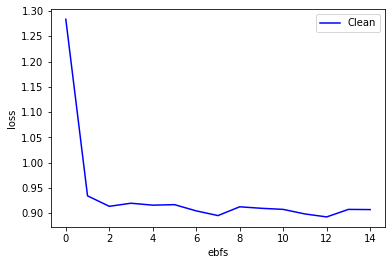

In [48]:
plot_htls([htl_0], ["Clean"])